In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
unemployment = pd.read_csv("data/unemployment.csv").set_index('Country Name')
# https://data.worldbank.org/indicator/SL.UEM.TOTL.ZS

year_dict = {}

years = list(range(2009,2019)) # These are the years with the most unemployment data

for year in years:
    freedom = pd.read_csv("data/freedom_" + str(year) + ".csv")
    # https://www.heritage.org/index/explore?view=by-region-country-year&u=637302137906965144
    
    # Merge freedom data with unemployment data
    df_temp = pd.merge(freedom, unemployment[str(year)], right_on = 'Country Name', left_on= 'Name')
    
    # Remove spaces from column names
    for name in df_temp.keys():
        df_temp = df_temp.rename(columns= {name: name.replace(" ", "")})
    
    # Change the year column to "Unemployment"
    df_temp = df_temp.rename(columns= {str(year): "Unemployment"})
    
    # Drop judicial effectiveness and fiscal health
    df_temp = df_temp.drop(columns=['JudicialEffectiveness', 'FiscalHealth'])
    
    # Drop rows with NaNs
    df_temp = df_temp.dropna()
    
    # Set index to country name
    df_temp = df_temp.set_index('Name')
    
    year_dict[year] = df_temp

In [3]:
# This is to remove the countries that do not have the full data

index_and = set(year_dict[2010].index)
index_or = set(year_dict[2010].index)

for year, data in year_dict.items():
    index_and = index_and & set(data.index)
    index_or = index_or | set(data.index)
    
drop_countries = index_or - index_and

for year in year_dict:
    year_dict[year] = year_dict[year].drop(index=drop_countries, errors='ignore')

In [4]:
# This is to create the dictionary using the countries as keys

country_dict = {}

for country in index_and:
    temp = pd.DataFrame()
    
    for year, data in year_dict.items():
        temp = temp.append(data.loc[[country]].set_index('IndexYear'))
    
    country_dict[country] = temp

In [5]:
# Example of a country's entry in country_dict

country_dict['Singapore']

,OverallScore,PropertyRights,GovernmentIntegrity,TaxBurden,GovernmentSpending,BusinessFreedom,LaborFreedom,MonetaryFreedom,TradeFreedom,InvestmentFreedom,FinancialFreedom,Unemployment
IndexYear,,,,,,,,,,,,
2009,87.1,90.0,93.0,91.1,93.8,98.3,98.1,86.8,90.0,80.0,50.0,5.860
2010,86.1,90.0,92.0,90.7,95.3,98.2,98.9,80.9,90.0,75.0,50.0,4.120
2011,87.2,90.0,92.0,91.1,91.3,98.2,98.0,86.2,90.0,75.0,60.0,3.890
2012,87.5,90.0,93.0,91.3,91.3,97.2,92.1,84.8,90.0,75.0,70.0,3.720
2013,88.0,90.0,92.0,91.1,91.3,97.1,91.4,82.0,90.0,75.0,80.0,3.860
2014,89.4,90.0,91.9,91.2,91.2,96.8,96.5,81.5,90.0,85.0,80.0,3.740
2015,89.4,90.0,86.0,91.2,93.8,96.9,96.9,83.7,90.0,85.0,80.0,3.790
2016,87.8,90.0,84.0,91.2,90.1,95.0,90.7,81.8,90.0,85.0,80.0,4.080
2017,88.6,97.1,87.9,90.5,90.1,95.1,90.8,84.3,90.0,85.0,80.0,4.200


Sum of Squared Differences Error 2240.5698375664556
Mean Percent Error 47.89802773067209


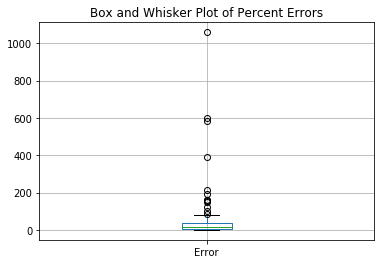

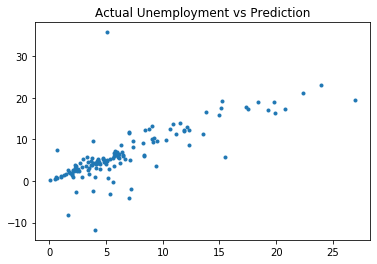

In [6]:
# Country analysis with linear regression

from sklearn.linear_model import LinearRegression

ssd_linear = 0

country_analysis_linear = pd.DataFrame(columns=['Name', 'Prediction', 'Actual'])

for country, data in country_dict.items():

    X_train = data.iloc[:-1,:-1]
    y_train = data.iloc[:-1,[-1]]
    X_test = data.iloc[[-1],:-1]
    y_test = data.iloc[[-1],[-1]]

    model = LinearRegression().fit(X_train, y_train)
    
    prediction = float(model.predict(X_test))
    actual = float(y_test.values)
    error = 100 * abs(prediction - actual) / actual
    
    ssd_linear += (prediction - actual)**2
    
    country_analysis_linear = country_analysis_linear.append(
        {'Name' : country,
         'Prediction' : prediction,
         'Actual' : actual,
         'Error' : error}, ignore_index=True)

country_analysis_linear = country_analysis_linear.set_index('Name')

print('Sum of Squared Differences Error', ssd_linear)
print('Mean Percent Error', np.mean(country_analysis_linear['Error']))

country_analysis_linear.boxplot(column='Error')
plt.title('Box and Whisker Plot of Percent Errors')
plt.show()

plt.figure()
plt.title('Actual Unemployment vs Prediction')
plt.plot(country_analysis_linear['Actual'], country_analysis_linear['Prediction'], linestyle="None", marker='.')
plt.show()

Sum of Squared Differences Error 275.02063829350215
Mean Percent Error 19.75666029928147


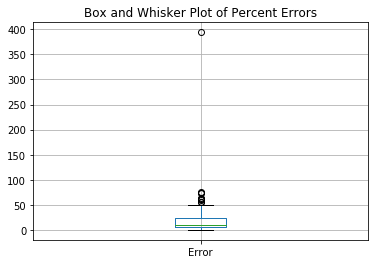

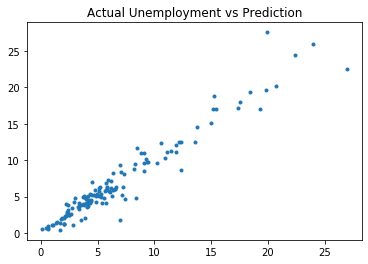

In [7]:
# Country analysis with kernel ridge

from sklearn.kernel_ridge import KernelRidge

ssd_ridge = 0

country_analysis_ridge = pd.DataFrame(columns=['Name', 'Prediction', 'Actual', 'Error'])

for country, data in country_dict.items():

    X_train = data.iloc[:-1,:-1]
    y_train = data.iloc[:-1,[-1]]
    X_test = data.iloc[[-1],:-1]
    y_test = data.iloc[[-1],[-1]]

    model = KernelRidge(alpha=1).fit(X_train, y_train)
    
    prediction = float(model.predict(X_test))
    actual = float(y_test.values)
    error = 100 * abs(prediction - actual) / actual
    
    ssd_ridge += (prediction - actual)**2
    
    country_analysis_ridge = country_analysis_ridge.append(
        {'Name' : country,
         'Prediction' : prediction,
         'Actual' : actual,
         'Error' : error}, ignore_index=True)

country_analysis_ridge = country_analysis_ridge.set_index('Name')

print('Sum of Squared Differences Error', ssd_ridge)
print('Mean Percent Error', np.mean(country_analysis_ridge['Error']))

country_analysis_ridge.boxplot(column='Error')
plt.title('Box and Whisker Plot of Percent Errors')
plt.show()

plt.figure()
plt.title('Actual Unemployment vs Prediction')
plt.plot(country_analysis_ridge['Actual'], country_analysis_ridge['Prediction'], linestyle="None", marker='.')
plt.show()

Sum of Squared Differences Error 158.78309100163668
Mean Percent Error 16.290759201734183


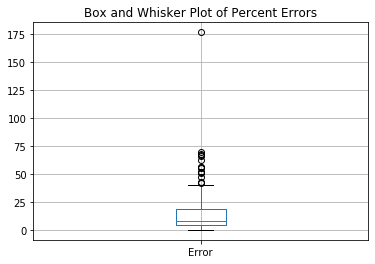

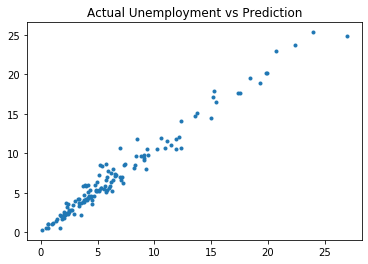

In [8]:
# Country analysis with lars lasso

from sklearn.linear_model import LassoLars

ssd_lasso = 0

country_analysis_lasso = pd.DataFrame(columns=['Name', 'Prediction', 'Actual', 'Error'])

for country, data in country_dict.items():

    X_train = data.iloc[:-1,:-1]
    y_train = data.iloc[:-1,[-1]]
    X_test = data.iloc[[-1],:-1]
    y_test = data.iloc[[-1],[-1]]

    model = LassoLars(alpha=.1).fit(X_train, y_train)
    
    prediction = float(model.predict(X_test))
    actual = float(y_test.values)
    error = 100 * abs(prediction - actual) / actual
    
    ssd_lasso += (prediction - actual)**2
    
    country_analysis_lasso = country_analysis_lasso.append(
        {'Name' : country,
         'Prediction' : prediction,
         'Actual' : actual,
         'Error' : error}, ignore_index=True)

country_analysis_lasso = country_analysis_lasso.set_index('Name')

print('Sum of Squared Differences Error', ssd_lasso)
print('Mean Percent Error', np.mean(country_analysis_lasso['Error']))

country_analysis_lasso.boxplot(column='Error')
plt.title('Box and Whisker Plot of Percent Errors')
plt.show()

plt.figure()
plt.title('Actual Unemployment vs Prediction')
plt.plot(country_analysis_lasso['Actual'], country_analysis_lasso['Prediction'], linestyle="None", marker='.')
plt.show()

Sum of Squared Differences Error 148.55402109378153
Mean Percent Error 11.412074346825115


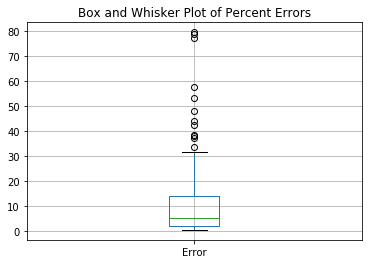

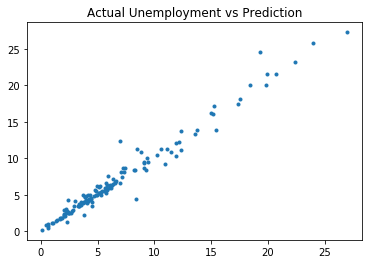

In [9]:
# Country analysis with neural networks

from sklearn.neural_network import MLPRegressor

ssd_neural = 0

country_analysis_neural = pd.DataFrame(columns=['Name', 'Prediction', 'Actual', 'Error'])

for country, data in country_dict.items():

    X_train = data.iloc[:-1,:-1]
    y_train = data.iloc[:-1,[-1]]
    X_test = data.iloc[[-1],:-1]
    y_test = data.iloc[[-1],[-1]]

    model = MLPRegressor(random_state=1, max_iter=3000, activation='logistic',
                         learning_rate='adaptive', solver='lbfgs').fit(X_train, y_train.values.ravel())
    
    prediction = float(model.predict(X_test))
    actual = float(y_test.values)
    error = 100 * abs(prediction - actual) / actual
    
    ssd_neural += (prediction - actual)**2
    
    country_analysis_neural = country_analysis_neural.append(
        {'Name' : country,
         'Prediction' : prediction,
         'Actual' : actual,
         'Error' : error}, ignore_index=True)

country_analysis_neural = country_analysis_neural.set_index('Name')

print('Sum of Squared Differences Error', ssd_neural)
print('Mean Percent Error', np.mean(country_analysis_neural['Error']))

country_analysis_neural.boxplot(column='Error')
plt.title('Box and Whisker Plot of Percent Errors')
plt.show()

plt.figure()
plt.title('Actual Unemployment vs Prediction')
plt.plot(country_analysis_neural['Actual'], country_analysis_neural['Prediction'], linestyle="None", marker='.')
plt.show()

In [10]:
# Example of a country's entry in country_dict

year_dict[2012]

,IndexYear,OverallScore,PropertyRights,GovernmentIntegrity,TaxBurden,GovernmentSpending,BusinessFreedom,LaborFreedom,MonetaryFreedom,TradeFreedom,InvestmentFreedom,FinancialFreedom,Unemployment
Name,,,,,,,,,,,,,
Albania,2012,65.1,35.0,33.0,91.4,69.5,78.2,51.0,78.6,79.8,65.0,70.0,13.376000
Algeria,2012,51.0,30.0,29.0,82.9,47.9,66.3,54.4,76.3,72.8,20.0,30.0,10.970000
Angola,2012,46.7,20.0,19.0,84.1,53.2,45.5,43.9,61.2,65.2,35.0,40.0,7.379000
Argentina,2012,48.0,20.0,29.0,65.5,56.9,61.0,48.9,60.7,67.6,40.0,30.0,7.217000
Armenia,2012,68.8,30.0,26.0,89.3,74.9,87.8,76.6,73.1,85.4,75.0,70.0,17.301001
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Uzbekistan,2012,45.8,15.0,16.0,94.4,64.9,67.6,60.1,64.2,66.1,0.0,10.0,4.870000
Vanuatu,2012,56.6,40.0,36.0,97.0,79.9,59.3,50.7,78.4,55.1,30.0,40.0,4.641000
Vietnam,2012,51.3,15.0,27.0,76.5,66.5,61.1,67.3,75.1,79.6,15.0,30.0,1.676000


In [11]:
# We picked 24 various nations that all had affects due to the great recession of 2008

countries_to_analyze = ['China', 'Canada', 'Japan', 'Germany', 
                        'United Kingdom', 'France', 'India', 'South Africa',
                        'Italy', 'Israel', 'Vietnam', 'Latvia', 
                        'Chile', 'Netherlands', 'Bhutan', 'Qatar',
                        'Turkey', 'Ukraine', 'Greece', 'Belgium',
                        'Ethiopia', 'Lesotho', 'Zimbabwe', 'Ghana']

In [12]:
# Yearly analysis with neural networks

from sklearn.neural_network import MLPRegressor

yearly_analysis_neural = pd.DataFrame(columns=['Year', 'Score'])

for year, data in year_dict.items():

    X_train = data.loc[~data.index.isin(countries_to_analyze), ~data.columns.isin(['Unemployment'])]
    X_test = data.loc[countries_to_analyze, ~data.columns.isin(['Unemployment'])]
    y_train = data.loc[~data.index.isin(countries_to_analyze), ['Unemployment']]
    y_test = data.loc[countries_to_analyze, ['Unemployment']]

    model = MLPRegressor(random_state=1, max_iter=5000, activation='logistic',
                         learning_rate='adaptive').fit(X_train, y_train.values.ravel())
    
    prediction = model.predict(X_test)
    
    yearly_analysis_neural = yearly_analysis_neural.append({'Year': year, 'Score': model.score(X_test, y_test)}, ignore_index=True)
    

yearly_analysis_neural['Year'] = yearly_analysis_neural['Year'].astype(int)
yearly_analysis_neural = yearly_analysis_neural.set_index('Year')

yearly_analysis_neural

,Score
Year,
2009,0.139663
2010,0.242222
2011,0.292534
2012,0.451128
2013,0.308387
2014,0.445866
2015,0.406520
2016,0.252423
2017,0.321830
